## Лабораторная 4: восстановление плотности распределения

Данными в этом задании являются измерения некоторых проверочных параметров на конвейерах  сборки оборудования Bosh (см. [конкурс](https://www.kaggle.com/c/bosch-production-line-performance) «Bosch Production Line Performance» на Kaggle). 

Все исходные данные Bosh не помещаются в оперативную память компьютера, поэтому в файле `data.csv` — лишь некоторые признаки. Прочтите данные из файла `data.csv`. Целевым признаком здесь является `Response` — наличие брака в оборудовании. 

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv', delimiter=',')
data.describe()

,L1_S24_F1844,L1_S24_F1846,Response
count,54729.000000,54729.000000,54729.000000
mean,0.000834,-0.000758,0.010123
std,0.190919,0.134541,0.100102
min,-0.406000,-0.622000,0.000000
25%,-0.146000,-0.120000,0.000000
50%,0.000000,-0.001000,0.000000
75%,0.143000,0.125000,0.000000
max,0.556000,0.355000,1.000000


## 1 
Постройте на одном графике два приближения к плотности распределения признака `L1_S24_F1846` для `Response = 0` и для `Response = 1`, используя одно из следующих ядер (номер ядра выберите по формуле: `(n mod 6) + 1`, где `n` — ваш номер в списке группы):

    1.	кусочно-постоянное (прямоугольное) -  tophat
    2.	гауссовское -  gaussian
    3.	линейное (треугольник) -  linear
    4.	косинусоидальное -  cosine
    5.	квадратичное (Епанечникова) -  epanechnikov
    6.	экспоненциальное -  exponential


In [3]:
from sklearn.neighbors import KernelDensity
import numpy as np

import matplotlib.pyplot as plt

*Help:*

    i0 = data['Response'] == 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
    X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
    Dens0 = np.exp(kde0.score_samples(X_plot))  # score_samples возвращает логарифм плотности

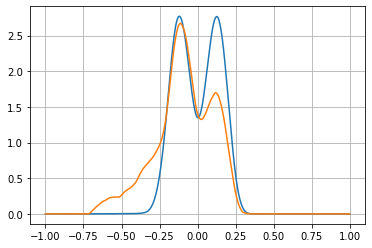

In [4]:
i0 = data['Response'] == 0
kde0 = KernelDensity(kernel='cosine', bandwidth=0.1).fit(data.loc[i0, 'L1_S24_F1846'].values.reshape(-1, 1))
X_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
Dens0 = np.exp(kde0.score_samples(X_plot)) 
i1 = data['Response'] == 1
kde1 = KernelDensity(kernel='cosine', bandwidth=0.1).fit(data.loc[i1, 'L1_S24_F1846'].values.reshape(-1, 1))
X_plot1 = np.linspace(-1, 1, 1000).reshape(-1, 1)
Dens1 = np.exp(kde1.score_samples(X_plot1))
plt.figure()
plt.grid()
plt.plot(X_plot, Dens0)
plt.plot(X_plot1, Dens1)
plt.show()

Ответьте в комментариях на вопрос: является ли выборка хорошо разделимой по признаку  `L1_S24_F1846`?

In [5]:
#Выборка плохо разделимоя, графики расположенны близко друг к другу

## 2

Разбейте выборку `data` на две равные части: тренировочную `dataTrain` и проверочную `dataTest`. 

In [6]:
dataTrain = data.loc[0:data.shape[0] / 2 - 1, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2 - 1:data.shape[0], ].reset_index(drop=True)


Пользуясь кросс-валидацией, подберите **для каждого класса `Response` (`r=0` и `r=1`)** значение ширины ядра `bandwidth`, при котором логарифм правдоподобия максимален на проверочной выборке.

*Help:*

    r = 0
    kde0 = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde0.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0 = kde0.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability0[np.isinf(logProbability0)] = -100 # заменяем -бесконечность
    logLikehood0 = logProbability0.sum()
    print(logLikehood0)

In [7]:
def LogLikeHood(r, BANDWIDTH, dataTrain, dataTest):
    kde = KernelDensity(kernel='cosine', bandwidth=BANDWIDTH)
    kde.fit(dataTrain.loc[dataTrain['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability = kde.score_samples(dataTest.loc[dataTest['Response']==r, 'L1_S24_F1846'].values.reshape(-1, 1))
    logProbability[np.isinf(logProbability)] = -100
    logLikehood = logProbability.sum()
    return logLikehood

In [8]:
log0 = dict()
log1 = dict()

In [9]:
for i in np.arange(0.01, 0.1, 0.01):
    log0[LogLikeHood(0, i, dataTrain, dataTest)] = i
log0Max = max(log0)
print("Max log:{} with bandwidth: {}".format(log0Max, log0[log0Max]))
maxBandWidth0 = log0[log0Max]

Max log:22105.891969752345 with bandwidth: 0.03


In [10]:
for i in np.arange(0.01, 0.1, 0.01):
    log1[LogLikeHood(1, i, dataTrain, dataTest)] = i
log1Max = max(log1)
print("Max log:{} with bandwidth: {}".format(log1Max, log1[log1Max]))
maxBandWidth1 = log1[log1Max]


Max log:114.5076291940499 with bandwidth: 0.05


### 3

Для найденных наилучших `bandwidth` вычислите `p(x|0)` и `p(x|1)` для тестовой выборки. 

In [11]:
dataTrain = data.loc[0:data.shape[0] / 2, ].reset_index(drop=True)
dataTest = data.loc[data.shape[0] / 2:data.shape[0], ].reset_index(drop=True)

In [12]:
kde0 = KernelDensity(kernel='cosine', bandwidth=maxBandWidth0)
kde0.fit(dataTrain.loc[dataTrain['Response']==0, 'L1_S24_F1846'].values.reshape(-1, 1))

kde1 = KernelDensity(kernel='cosine', bandwidth=maxBandWidth1)
kde1.fit(dataTrain.loc[dataTrain['Response']==1, 'L1_S24_F1846'].values.reshape(-1, 1))

predictionProbXafter0 = np.exp(kde0.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))
predictionProbXafter1 = np.exp(kde1.score_samples(dataTest['L1_S24_F1846'].values.reshape(-1, 1)))

По формуле Байеса найдите затем `p(0|x)` и `p(1|x)`. Отсортируйте все объекты тестовой выборки по возрастанию предсказанной вероятности `p(1|x)`, выведите на экран вероятности для последних 10 объектов и рассчитайте количество бракованных деталей среди последних 100 объектов в отсортированном ряду.

*Help:*
    
    ind = np.argsort(predictionProb1afterX) - сортировка, возвращающая индексы элементов
    print(predictionProb1afterX[ind[-10:]]) - вывод последних 10 элементов
    print(sum(dataTest.loc[ind[-100:],'Response'])) - количество бракованных среди 100 с максимальной вероятностью брака

In [13]:
predictionProb0 = len(dataTest.loc[dataTest['Response']==0]) / dataTest.shape[0]
predictionProb1 = len(dataTest.loc[dataTest['Response']==1]) / dataTest.shape[0]
predictionProbXafter0 = predictionProbXafter0 * predictionProb0
predictionProbXafter1 = predictionProbXafter1 * predictionProb1
predictionProbX = predictionProbXafter0 + predictionProbXafter1
predictionProb0afterX = predictionProbXafter0 / predictionProbX
predictionProb1afterX = predictionProbXafter1 / predictionProbX


C:\Users\7636~1\AppData\Local\Temp/ipykernel_9264/2124952393.py:6: RuntimeWarning: invalid value encountered in true_divide
  predictionProb0afterX = predictionProbXafter0 / predictionProbX
C:\Users\7636~1\AppData\Local\Temp/ipykernel_9264/2124952393.py:7: RuntimeWarning: invalid value encountered in true_divide
  predictionProb1afterX = predictionProbXafter1 / predictionProbX


In [14]:
ind = np.argsort(predictionProb1afterX) 
print(predictionProb1afterX[ind[-10:]])
print(sum(dataTest.loc[ind[-100:],'Response']))

[0.59138396 0.59140535 0.59984898 0.60626673 0.60626673 0.61699998
 0.62428965 0.62627663        nan        nan]
29
